In [2]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, Binarizer, OrdinalEncoder, OneHotEncoder)
from sklearn.metrics import (confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve)
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import folium

In [156]:
necessary = False
if necessary:
    df = pd.read_csv('vehicles.csv')

    # define the number of parts to split the dataframe
    num_parts = 20

    # calculate the number of rows in each part
    rows_per_part = len(df) // num_parts

    # split the dataframe into multiple parts
    for i in range(num_parts):
        start_idx = i * rows_per_part
        end_idx = start_idx + rows_per_part
        if i == num_parts - 1:
            end_idx = len(df)
        df_part = df[start_idx:end_idx]
        df_part.to_csv(f'part_{i+1}.csv', index=False)
        
if not necessary:
    # concatenate the 20 CSV files into a single DataFrame
    df_list = []
    for i in range(1, 21):
        filename = f"part_{i}.csv"
        df_part = pd.read_csv(filename)
        df_list.append(df_part)
    df = pd.concat(df_list)

    # reset the index of the concatenated DataFrame
    df.reset_index(drop=True, inplace=True)


In [157]:
df.head(10)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN
5,7222379453,https://hudsonvalley.craigslist.org/cto/d/west...,hudson valley,https://hudsonvalley.craigslist.org,1600,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN
6,7221952215,https://hudsonvalley.craigslist.org/cto/d/west...,hudson valley,https://hudsonvalley.craigslist.org,1000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN
7,7220195662,https://hudsonvalley.craigslist.org/cto/d/poug...,hudson valley,https://hudsonvalley.craigslist.org,15995,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN
8,7209064557,https://medford.craigslist.org/cto/d/grants-pa...,medford-ashland,https://medford.craigslist.org,5000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,or,NaN,NaN,NaN
9,7219485069,https://erie.craigslist.org/cto/d/erie-2012-su...,erie,https://erie.craigslist.org,3000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,pa,NaN,NaN,NaN


In [158]:
### Printing summary of raw data
print(df.shape)
df.columns

(426880, 26)


Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [5]:
df.describe()

,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


In [6]:
# Number of non-null values in each column
missing_values = (df.isna().sum()/df.shape[0]).sort_values(ascending=False)
print(missing_values)

county          1.000000
size            0.717675
cylinders       0.416225
condition       0.407852
VIN             0.377254
drive           0.305863
paint_color     0.305011
type            0.217527
manufacturer    0.041337
title_status    0.019308
lat             0.015342
long            0.015342
model           0.012362
odometer        0.010307
fuel            0.007058
transmission    0.005988
year            0.002823
description     0.000164
image_url       0.000159
posting_date    0.000159
url             0.000000
price           0.000000
state           0.000000
region_url      0.000000
region          0.000000
id              0.000000
dtype: float64


In [7]:
np.count_nonzero(df[['price','VIN']].value_counts().duplicated())

122079

In [8]:

def count_duplicates(df, col_names):
    # Find duplicated values in the specified columns
    duplicated_values = df[df.duplicated(subset=col_names, keep=False)]

    # Count the number of duplicated values
    num_duplicates = len(duplicated_values)

    return num_duplicates

col_names = ['posting_date', 'VIN', 'price']
num_duplicates = count_duplicates(df, col_names)
num_duplicates

2196

In [9]:
col_names = ['VIN', 'posting_date']
num_duplicates = count_duplicates(df, col_names)
num_duplicates

9045

In [10]:
np.count_nonzero(df['VIN'].duplicated())

308615

<Axes: >

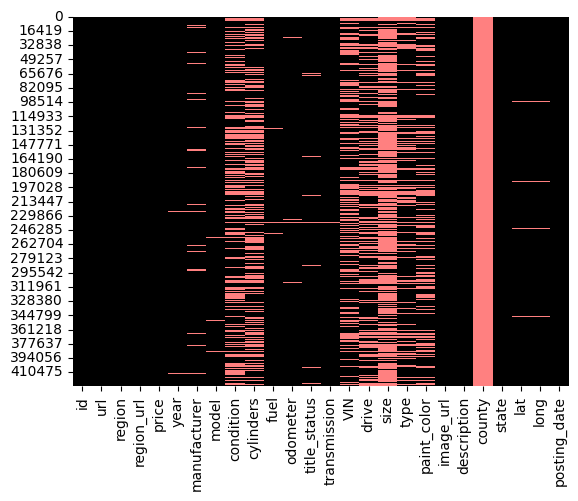

In [11]:
from matplotlib.colors import LinearSegmentedColormap

# Define the custom color map
custom_cmap = LinearSegmentedColormap.from_list(
    'custom', [(0, 0, 0), (1, 1, 1), (1, 0.5, 0.5)])

# Generate the missing values matrix
msk = df.isna()

# Generate the heatmap with the custom color map
sns.heatmap(msk, cmap=custom_cmap, cbar=False)

In [12]:
def get_missing_correlation(df):
    """
    Get the correlation matrix of missing values in a DataFrame.

    Parameters:
    -----------
    df: pandas DataFrame
        The DataFrame to check for missing value correlation.

    Returns:
    --------
    Tuple
        A tuple containing a boolean indicating if there is high correlation, 
        the mean correlation, the max correlation, and the column pairs with the 
        highest correlation.
    """
    # Create a missing values matrix
    msk = df.isna()

    # Calculate the correlation matrix of the missing values matrix
    corr_matrix = np.abs(msk.corr())

    # Replace NaN values with 0
    corr_matrix = np.nan_to_num(corr_matrix)
    
    # Set diagonal to 0
    np.fill_diagonal(corr_matrix, 0)

    # Calculate the mean and max correlation across all pairs of features
    mean_corr = np.mean(corr_matrix)
    max_corr = np.max(np.nan_to_num(corr_matrix))

    # Find the column pairs with the highest correlation
    max_corr_idxs = np.argwhere((0.5 <= corr_matrix) & 
                                (corr_matrix <= max_corr))
    max_corr_pairs = [(df.columns[i], df.columns[j]) for i, j in zip(*max_corr_idxs.T)]

    # Return True if the mean correlation is greater than 0.5, False otherwise
    if mean_corr > 0.5:
        return True, mean_corr, max_corr, max_corr_pairs
    else:
        return False, mean_corr, max_corr, max_corr_pairs


    
    
    
get_missing_correlation(df)


(False,
 0.05491979425755076,
 1.0,
 [('image_url', 'description'),
  ('image_url', 'posting_date'),
  ('description', 'image_url'),
  ('description', 'posting_date'),
  ('lat', 'long'),
  ('long', 'lat'),
  ('posting_date', 'image_url'),
  ('posting_date', 'description')])

In [13]:
# create a dictionary to map state abbreviations to full names
state_dict = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}

# Group the data by state and count the number of listings in each state
state_counts = df.groupby('state').size().reset_index(name='count')

# Calculate the mean and median price by state
state_price = df.groupby('state')['price'].agg(['median']).reset_index()

# Map state abbreviations to full names in the state_counts and state_price DataFrames
state_counts['state'] = state_counts['state'].str.upper().map(state_dict)
state_price['state'] = state_price['state'].str.upper().map(state_dict)

# Create a choropleth map using folium
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add layer for listing frequency
m.choropleth(
    geo_data='us-states.json',
    name='Listing Frequency',
    data=state_counts,
    columns=['state', 'count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Listings',
    legend_scale=5000  # set legend scale to increase the size
)


# Add layer for median price
m.choropleth(
    geo_data='us-states.json',
    name='Median Price',
    data=state_price,
    columns=['state', 'median'],
    key_on='feature.properties.name',
    fill_color='Purples',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median Price ($)',
    legend_scale=5000  # set legend scale to increase the size
)

folium.LayerControl().add_to(m)

m

c:\Users\Zaki Ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\folium\folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(
c:\Users\Zaki Ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\folium\folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


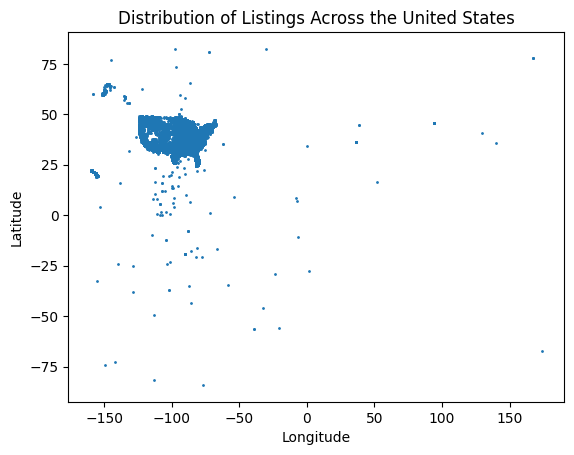

In [14]:
import matplotlib.pyplot as plt

# create a scatter plot of latitudes and longitudes
plt.scatter(df['long'], df['lat'], s=1)

# set axis labels and plot title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of Listings Across the United States')

# show the plot
plt.show()

In [16]:
df = df.dropna(subset=['lat', 'long'])  # remove rows with missing lat/long
df = df.sample(n=1000, random_state=42)

# Create a map centered on the US
us_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Create a feature group to hold the markers
marker_group = folium.FeatureGroup(name='Listings')

# Add a marker for each listing
for index, row in df.iterrows():
    # Create a popup with some information about the listing
    popup_text = f"Model: {row['model']}<br>Price: {row['price']}"
    
    # Add the marker to the marker group
    folium.Marker(location=[row['lat'], row['long']], popup=popup_text).add_to(marker_group)

# Add the marker group to the map
marker_group.add_to(us_map)

# Add a layer control to the map
folium.LayerControl().add_to(us_map)
#resetting df
df = pd.read_csv('vehicles.csv')
# Show the map
us_map

In [42]:
df_clean = df.drop(columns=['county', 'id', 'url', 'region_url', 'image_url'])
df_clean.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,...,VIN,drive,size,type,paint_color,description,state,lat,long,posting_date
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [118]:
from scipy.stats import percentileofscore

arr = np.array(df['price'])

# Find percentile of a value
percentilelo = percentileofscore(arr, 200)
percentilehi = percentileofscore(arr, 350000)

print(percentilelo, percentilehi)
print(percentilehi-percentilelo)

8.841946214392804 99.98313343328336
91.14118721889055


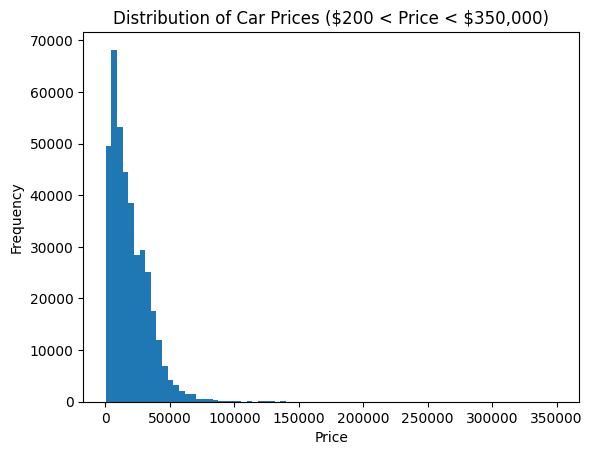

In [123]:
df_clean = df.drop(columns=['county', 'id', 'url', 'region_url', 'image_url'])
df_clean = df_clean[(df_clean['price'] > 200) & (df_clean['price'] < 350000)]




# Plot histogram of price
plt.hist(df_clean['price'], bins=80, range=(df_clean['price'].quantile(0), df_clean['price'].quantile(1)))
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Car Prices (\$200 < Price < \$350,000)')
plt.show()


In [124]:
df_clean['price'].describe()

count    389034.000000
mean      19133.746788
std       15289.913373
min         201.000000
25%        7500.000000
50%       15590.000000
75%       27982.000000
max      349999.000000
Name: price, dtype: float64

In [141]:
arr = np.array(df_clean['price'])

# Find percentile of a value
percentilelo = percentileofscore(arr, 0)
percentilehi = percentileofscore(arr, 46000)

print(percentilelo, percentilehi)
print(percentilehi-percentilelo)

0.0 95.34565102278978
95.34565102278978


In [125]:
df_clean.shape

(389034, 21)

In [90]:
df[df['price']==df_clean['price'].max()]

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
45428,7306488355,https://palmsprings.craigslist.org/ctd/d/palm-...,palm springs,https://palmsprings.craigslist.org,349999,2020.0,ferrari,f8 tributo,excellent,8 cylinders,...,NaN,coupe,NaN,https://images.craigslist.org/00909_j4EPGT4nxI...,ONE OF A KIND 2020 Ferrari F8 Tributo Coupe ...,NaN,ca,33.743904,-116.359028,2021-04-13T18:20:46-0700


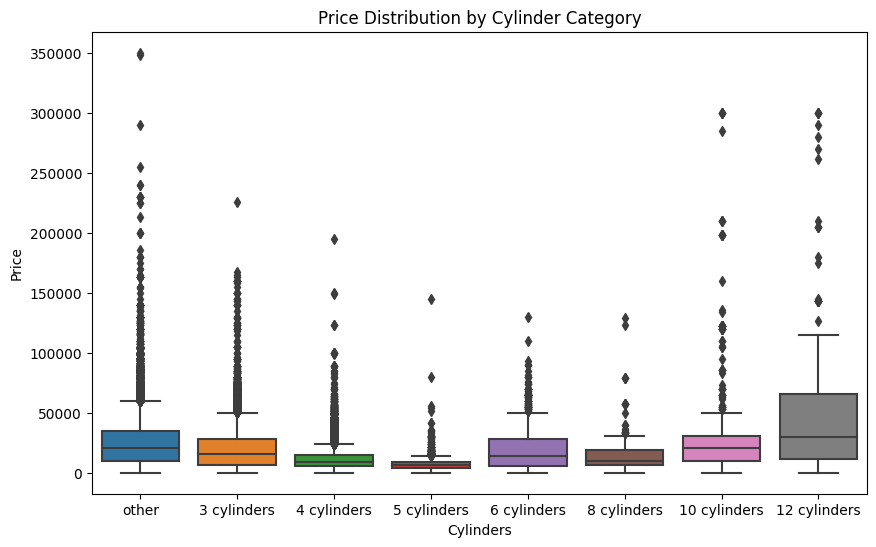

In [138]:
# create a dictionary to map cylinder categories to numerical values
cylinder_order = {'other': 0, '3 cylinders': 1, '4 cylinders': 2, '5 cylinders': 3, '6 cylinders': 4, '8 cylinders': 5, '10 cylinders': 6, '12 cylinders': 7}

# create a new column in the DataFrame with the numerical values
df_bp = df_clean
df_bp['cylinders_order'] = df_bp['cylinders'].map(cylinder_order)

# create a boxplot
fig, ax = plt.subplots(figsize=(10, 6))  # set the figsize parameter to adjust the plot width
sns.boxplot(x='cylinders', y='price', data=df_bp, whis=1, ax=ax)

# set title and axis labels
ax.set_title('Price Distribution by Cylinder Category')
ax.set_xlabel('Cylinders')
ax.set_ylabel('Price')

# set the tick labels for the x-axis to the cylinder categories
plt.xticks(range(len(cylinder_order)), sorted(cylinder_order, key=lambda x: cylinder_order[x]))

# display the plot
plt.show()

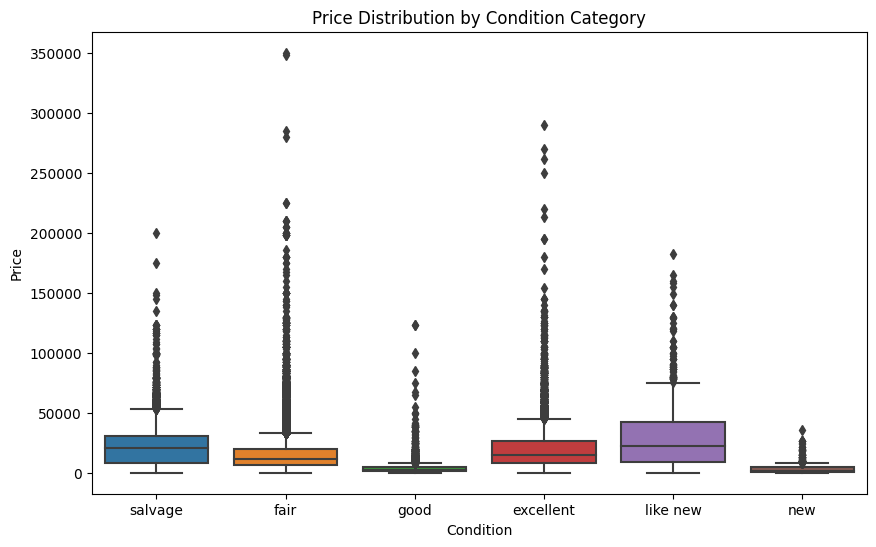

In [142]:
# create a dictionary to map condition categories to numerical values
condition_order = {'salvage': 0, 'fair': 1, 'good': 2, 'excellent': 3, 'like new': 4, 'new': 5}

# create a new column in the DataFrame with the numerical values
df_bp = df_clean
df_bp['condition_order'] = df_bp['condition'].map(condition_order)

# create a boxplot
fig, ax = plt.subplots(figsize=(10, 6))  # set the figsize parameter to adjust the plot width
sns.boxplot(x='condition', y='price', data=df_bp, whis=1, ax=ax)

# set title and axis labels
ax.set_title('Price Distribution by Condition Category')
ax.set_xlabel('Condition')
ax.set_ylabel('Price')

# set the tick labels for the x-axis to the condition categories
plt.xticks(range(len(condition_order)), sorted(condition_order, key=lambda x: condition_order[x]))

# display the plot
plt.show()

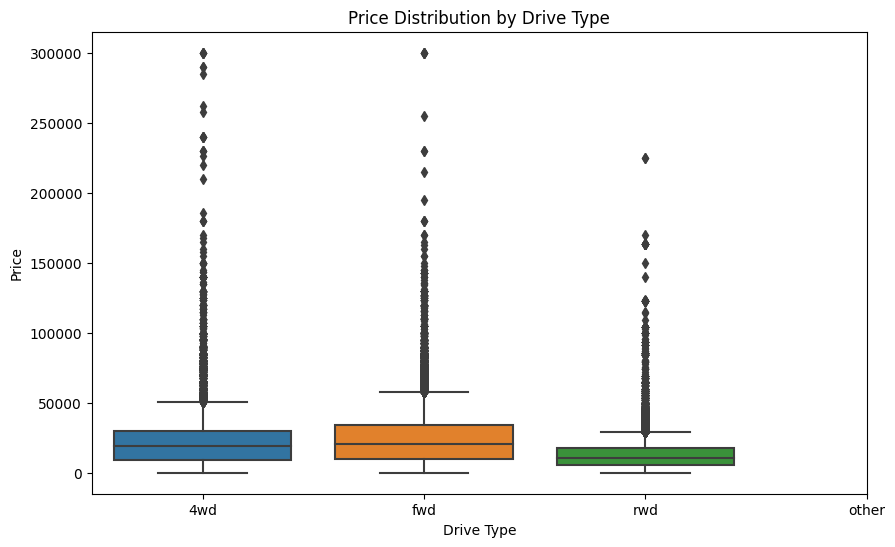

In [150]:
# create a dictionary to map drive type categories to numerical values
drive_order = {'4wd': 0, 'fwd': 1, 'rwd': 2, 'other': 3}

# create a new column in the DataFrame with the numerical values
df_bp = df_clean.copy()
df_bp['drive_order'] = df_bp['drive'].map(drive_order)

# create a boxplot
fig, ax = plt.subplots(figsize=(10, 6))  # set the figsize parameter to adjust the plot width
sns.boxplot(x='drive', y='price', data=df_bp, whis=1, ax=ax)

# set title and axis labels
ax.set_title('Price Distribution by Drive Type')
ax.set_xlabel('Drive Type')
ax.set_ylabel('Price')

# set the tick labels for the x-axis to the drive type categories
plt.xticks(range(len(drive_order)), sorted(drive_order, key=lambda x: drive_order[x]))

# display the plot
plt.show()

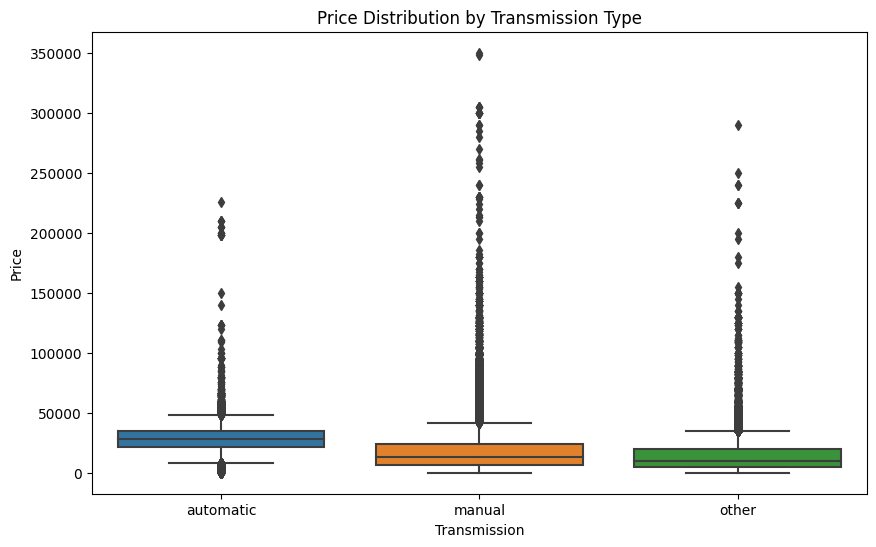

In [151]:
# create a dictionary to map condition categories to numerical values
transmission_order = {'automatic': 0, 'manual': 1, 'other': 2}

# create a new column in the DataFrame with the numerical values
df_bp = df_clean
df_bp['transmission_order'] = df_bp['transmission'].map(transmission_order)

# create a boxplot
fig, ax = plt.subplots(figsize=(10, 6))  # set the figsize parameter to adjust the plot width
sns.boxplot(x='transmission', y='price', data=df_bp, whis=1, ax=ax)

# set title and axis labels
ax.set_title('Price Distribution by Transmission Type')
ax.set_xlabel('Transmission')
ax.set_ylabel('Price')

# set the tick labels for the x-axis to the transmission categories
plt.xticks(range(len(transmission_order)), sorted(transmission_order, key=lambda x: transmission_order[x]))

# display the plot
plt.show()

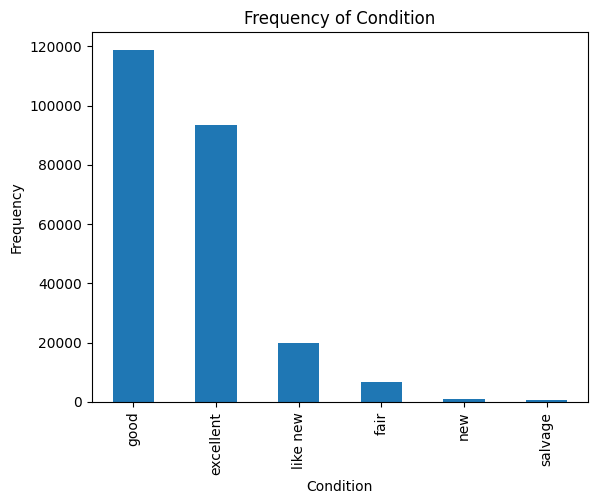

In [143]:
# count the frequency of each condition
condition_counts = df_clean['condition'].value_counts()

# create a bar chart
ax = condition_counts.plot(kind='bar')

# set title and axis labels
ax.set_title('Frequency of Condition')
ax.set_xlabel('Condition')
ax.set_ylabel('Frequency')

# display the plot
plt.show()

In [149]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

def get_corr_with_price(df):
    # select only the numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    
    # create a new DataFrame to store the results
    result_df = pd.DataFrame(columns=["column_name", "corr_with_price", "r_squared"])
    
    # loop over the numerical columns
    for col in numerical_cols:
        # drop any rows that contain missing values in the selected column
        df_temp = df.dropna(subset=[col])
        
        # create a new DataFrame with the selected column and the price column
        X = df_temp[[col]]
        y = df_temp["price"]
        
        # impute missing values with the mean of the column
        imputer = SimpleImputer()
        X_imputed = imputer.fit_transform(X)
        
        # fit a linear regression model to the data and calculate R^2
        model = LinearRegression()
        model.fit(X_imputed, y)
        r_squared = model.score(X_imputed, y)
        
        # calculate the Pearson correlation coefficient with the "price" column
        corr_with_price = df_temp[[col, "price"]].corr().iloc[0,1]
        
        # append the results to the result DataFrame
        result_df = result_df.append({"column_name": col, "corr_with_price": corr_with_price, "r_squared": r_squared}, ignore_index=True)
    
    # sort by absolute correlation values in descending order
    result_df = result_df.iloc[(-result_df['corr_with_price'].abs()).argsort()]
    
    return result_df

df_corr_with_price = get_corr_with_price(df_clean)
df_corr_with_price

C:\Users\Zaki Ahmed\AppData\Local\Temp\ipykernel_18564\3503054492.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({"column_name": col, "corr_with_price": corr_with_price, "r_squared": r_squared}, ignore_index=True)
C:\Users\Zaki Ahmed\AppData\Local\Temp\ipykernel_18564\3503054492.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({"column_name": col, "corr_with_price": corr_with_price, "r_squared": r_squared}, ignore_index=True)
C:\Users\Zaki Ahmed\AppData\Local\Temp\ipykernel_18564\3503054492.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({"column_name": col, "corr_with_price": corr_with_price, "r_squared": r_squared}, ignor

,column_name,corr_with_price,r_squared
0,price,1.000000,1.000000
1,year,0.331266,0.109737
2,odometer,-0.175103,0.030661
4,long,-0.080492,0.006479
3,lat,-0.011804,0.000139


In [148]:
df_clean = df.drop(columns=['county', 'id', 'url', 'region_url', 'image_url'])
df_clean = df_clean[(df_clean['price'] > 200) & (df_clean['price'] < 350000)]
df_clean

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,...,VIN,drive,size,type,paint_color,description,state,lat,long,posting_date
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,...,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,Carvana is the safer way to buy a car During t...,wy,33.786500,-84.445400,2021-04-04T03:21:31-0600
426876,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,...,7JR102FKXLG042696,fwd,NaN,sedan,red,Carvana is the safer way to buy a car During t...,wy,33.786500,-84.445400,2021-04-04T03:21:29-0600
426877,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,...,1GYFZFR46LF088296,NaN,NaN,hatchback,white,Carvana is the safer way to buy a car During t...,wy,33.779214,-84.411811,2021-04-04T03:21:17-0600
426878,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,...,58ABK1GG4JU103853,fwd,NaN,sedan,silver,Carvana is the safer way to buy a car During t...,wy,33.786500,-84.445400,2021-04-04T03:21:11-0600
